{/* cspell:ignore Lipinska webkitallowfullscreen allowfullscreen referrerpolicy Ardle IIIZ IZII IIZI ZIII IZIZ IIZZ ZIIZ IZZI ZZII ZIZI XXYY YYXX disp workstream */}

# Bringing it all together with Qiskit Runtime

## Summary

Victoria Lipinska gives a final recap of what we have learned so far.

<IBMVideo id="132414925" title="Victoria Lipinska gives an overview of what we have learned so far, combining the Hamiltonian, ansatz, and classical optimizer elements into a VQE calculation."/>

### References
The following articles are referenced in the above video.
* [Quantum Chemistry in the Age of Quantum Computing, Cao, et al.](https://arxiv.org/pdf/1812.09976.pdf)
* [Quantum computational chemistry, McArdle, et al.](https://arxiv.org/pdf/1808.10402.pdf)

## VQE with Qiskit Patterns

We have all the necessary components for a VQE calculation:

* Hamiltonian
* Ansatz
* Classical optimizer

Now we just have to bring them together in the Qiskit Patterns framework.

## Step 1: Map classical inputs to a quantum problem

As stated previously, we will assume here that a suitably formatted Hamiltonian of interest has already been generated. If you have questions about that, please see the [lesson on Hamiltonians](/learning/courses/quantum-chem-with-vqe/hamiltonian-construction) for guidance. The code block below sets up the components explained in previous lessons. Here we have chosen to model H2 because its Hamiltonian is compact enough to write out.

In [1]:
# General imports
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# Hamiltonian obtained from a previous lesson

H = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)

nuclear_repulsion = 0.7199689944489797

We select an efficient_su2 circuit, and the optimizer COBYLA, to start.

5


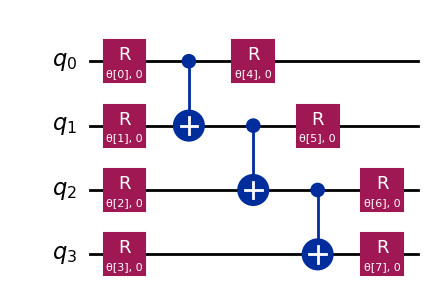

In [2]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions

# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

Now we construct our cost function. This is obviously related to the Hamiltonian, but differs in that the Hamiltonian is an operator, and we want a function that returns the expectation value of that operator, using Estimator. Of course, it accomplishes this by using the ansatz and the variational parameters, so all these show up as arguments. Below, we define slightly different versions for use on real hardware or simulators.

In [3]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy


# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

## Step 2: Optimize problem for quantum execution.

We want our code to run as efficiently as possible on the hardware we use. So we must select a backend to begin the optimization step. The code below selects the least busy backend available to you.

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

Optimizing the circuit for running on a real backend is a rich and critical topic. But it is not specific to VQE. For now, we will simply remind you of two important terms:

* **[optimization\_level](/docs/api/qiskit/transpiler#preset-pass-managers)**: This describes how well the circuit is tailored to the layout of the backend selected. The lowest optimization level just does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.
* **[Dynamical Decoupling](/docs/api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling)**: We can apply a sequence of gates to idling qubits. This cancels out some unwanted interactions with the environment.
  Consult the linked documentation for more information on optimizing circuits. The code below generates a mass manager using preset pass managers from `qiskit.transpiler`.

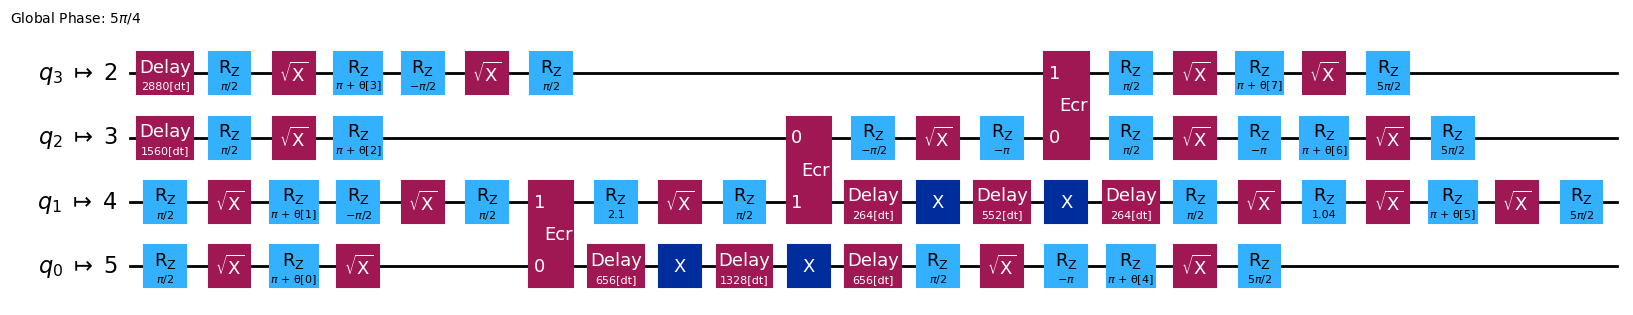

In [19]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)


# Use the pass manager and draw the resulting circuit
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

We must similarly apply device layout characteristics to the Hamiltonian.

In [20]:
hamiltonian_isa = H.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 3: Execute using Qiskit Primitives.

Before we execute on the selected hardware, it is a good idea to use a simulator for cursory debugging, and sometimes for estimates of error. For those reasons, we briefly show how to run VQE on a simulator. But it is critical to note that **no classical computer, simulator, or GPU** can accurately simulate the full functionality of a highly-entangled 127-qubit quantum computer. In the present era of quantum utility, simulators will have limited use.

Recall that for each choice of parameters in the variational circuit, an expectation value must be calculated (since that is the value to be minimized). As you may have already guessed, the most efficient way to do that is using the Qiskit primitive, Estimator. We'll start by using a local simulator, which will require that we use the local version of Estimator called BackendEstimator.

Keeping the real backend we used for optimization, we can import a model of the noise behavior of that device to then use with the local simulator of our choice. Here, we will use the aer_simulator_statevector.

In [23]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator

# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendEstimatorV2

# generate a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)
estimator = BackendEstimatorV2(backend=backend_sim)

It is finally time to implement VQE, minimizing the cost function using the selected Hamiltonian, ansatz, classical optimizer, and our BackendEstimator, based on the real backend we selected for subsequent use. Note that here we have chosen a relatively small number for the maximum iterations. This is because we are merely using the simulator to debug. VQE optimization steps often require hundreds of iterations to converge.

In [24]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
    options={"maxiter": 10, "disp": True},
)

print(getattr(res, "fun") - nuclear_repulsion)
print(res)

Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 10   Least value of F = -0.11556938907226563
The corresponding X is:
[4.11796514 4.52126324 0.69570423 4.12781503 6.55507846 1.80713073
 0.9645473  6.23812214]

-0.8355383835212453
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -0.11556938907226563
       x: [ 4.118e+00  4.521e+00  6.957e-01  4.128e+00  6.555e+00
            1.807e+00  9.645e-01  6.238e+00]
    nfev: 10
   maxcv: 0.0


This code evaluated correctly, though it did not converge, which we expected. We will proceed running the calculation on real hardware, and then discuss the outputs. For real backends, we will use the Qiskit Runtime Estimator. We will want to execute this inside a Qiskit Runtime session and we will generally want to specify options for that session.

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.options import EstimatorOptions

Among other things, using a session means our job will only wait in the queue once, to begin. Subsequent iterations of the classical optimizer will not be queued. In the session, we can set resilience and optimization levels. These tools are important enough that we include a brief review of each and their importance in VQE, with links to learn more:

* Runtime sessions: VQE is inherently iterative, with the classical optimizer selecting new variational parameters, and thus new gates being used, in each subsequent trial. Without using sessions, this could result in additional queue time between each trial circuit. Encapsulating the VQE calculation inside a session results in only one initial queue prior to the job's start, but no additional queue time between variational steps. This strategy was already used in the previous lesson's example, but may play an even more important role when varying geometry. For more about sessions, review the  [execution modes documentation](/docs/guides/execution-modes).
* Estimator's built-in optimization: In Estimator there are built-in options for optimizing a calculation. In many contexts (Estimator included), settings are limited to 0 and 1, with 0 indicating no optimization, and 1 (the default) indicating some optimization of your circuit to hardware selected. Some other contexts allow settings of  0, 1, 2, or 3. For more on the specific methods used in different settings, see the [documentation](/docs/api/qiskit-ibm-runtime/options-estimator-options). Here, we will actually set optimization to 0, and use 'skip\_transpilation = true', because we have already transpiled our circuit using the pass manager above, in the optimization section.
* Estimator's built-in resilience: As with optimization, Estimator has built-in settings for resilience against errors, corresponding to different approaches to error mitigation. To learn about resilience level settings, refer to the  [documentation](/docs/guides/configure-error-mitigation).

It is worth noting that error mitigation plays a nuanced role in the convergence of a VQE calculation. The classical optimizer is searching parameter space for those parameters that minimize the energy. When you are very far from the optimal parameters, a steep gradient may be apparent to the classical optimizer even in the presence of errors. But as the calculation converges and you approach the optimal values, the gradient becomes smaller, and more easily washed out by errors. How much error mitigation do you want to use? At what points in the convergence? These are choices you must make for your particular use case.

For this first hardware run, we have set resilience to 0 to facilitate a relatively fast run. For any serious application, you will want to use error mitigation. Note that in the cell below there are two sets of options: (1) options for the Runtime session, which we have named "session\_options", and (2) options for the classical optimizer, simply called "options" here.

In [12]:
estimator_options = EstimatorOptions(resilience_level=0, default_shots=2000)
with Session(backend=backend) as session:
    estimator = Estimator(mode=session, options=estimator_options)

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
        options={"maxiter": 10, "disp": True},
    )

/home/porter284/.pyenv/versions/3.11.12/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 10   Least value of F = -0.11691688904
The corresponding X is:
[5.11796514 5.52126324 0.69570423 5.12781503 6.55507846 1.80713073
 1.9645473  6.23812214]



You can view the progress of your job on the IBM Quantum Platform under [Workloads](https://quantum.cloud.ibm.com/workloads).

In [13]:
print(getattr(res, "fun") - nuclear_repulsion)
print(res)

-0.8368858834889796
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -0.11691688904
       x: [ 5.118e+00  5.521e+00  6.957e-01  5.128e+00  6.555e+00
            1.807e+00  1.965e+00  6.238e+00]
    nfev: 10
   maxcv: 0.0


## Step 4: Post-process, return result in classical format.

Let's take a moment to ensure we understand these outputs. The "**fun**" output is the **minimum** value we obtained for the cost function (not necessarily the last value calculated). This is the total energy, including the positive nuclear repulsion, which is why we also defined electron\_energy.

In the case above, we have a message that the maximum number of function evaluations was exceeded, and that the number of function evaluations (**nfev**) was 10. This simply means that other criteria for convergence of the optimization were not met; in other words, there is no reason to think we found the ground state energy. This is also the meaning of **success** being "False".

Finally, we have **x**. This is the vector of variational parameters. These are the parameters used in the calculation that yielded the minimum cost function (energy expectation value). These eight values correspond to the eight rotation angles in those gates in the ansatz that take variable rotation angles.

Congratulations! You have run a VQE calculation on an IBM Quantum System!

In the next lesson, we will see how to adjust this workstream to include variables in your Hamiltonian. In the context of quantum chemistry problems, this might mean varying geometry to determine shapes of molecules or binding sites.

In [14]:
import qiskit
import qiskit_ibm_runtime

print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

2.1.0
0.40.1
